In [1]:
%matplotlib inline
%load_ext Cython
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy import stats
from scipy.optimize import curve_fit

from lmfit.models import *
from pyarrow import csv

import warnings
warnings.filterwarnings('ignore')

#from palettable.wesanderson import Zissou_5
#from cycler import cycler
#plt.rc('axes', prop_cycle=cycler('color', Zissou_5.mpl_colors)) 

MP = 0.93827208816
E0 = 4.81726
ME = 0.00051099895

In [2]:
%%cython --annotate
import numpy as np
cimport numpy as np
from libc.math cimport sin, cos, sqrt
from scipy import stats
cimport cython

cdef float MP = 0.93827208816
cdef float E0 = 4.81726
cdef float ME = 0.00051099895

cdef float p_targ_px = 0.0
cdef float p_targ_py = 0.0
cdef float p_targ_pz = 0.0
cdef float p_targ_E = MP

cdef float e_beam_px = 0.0
cdef float e_beam_py = 0.0
cdef float e_beam_pz = sqrt(E0**2-ME**2)
cdef float e_beam_E = E0

@np.vectorize
def calc_W(float e_p, float e_theta, float e_phi):
    cdef float e_prime_px = e_p*sin(e_theta)*cos(e_phi)
    cdef float e_prime_py = e_p*sin(e_theta)*sin(e_phi)
    cdef float e_prime_pz = e_p*cos(e_theta)
    cdef float e_prime_E = sqrt(e_prime_px**2 + e_prime_py**2 + e_prime_pz**2 - ME**2)
    
    cdef float temp_px = e_beam_px - e_prime_px + p_targ_px
    cdef float temp_py = e_beam_py - e_prime_py + p_targ_py
    cdef float temp_pz = e_beam_pz - e_prime_pz + p_targ_pz
    cdef float temp_E = e_beam_E - e_prime_E + p_targ_E
    
    
    cdef float temp2 = temp_px**2+temp_py**2+temp_pz**2-temp_E**2
    cdef float temp3 = sqrt(-temp2)
    
    
    return temp3


@np.vectorize
def calc_q2(float e_p, float e_theta, float e_phi):
    cdef float e_prime_px = e_p*sin(e_theta)*cos(e_phi)
    cdef float e_prime_py = e_p*sin(e_theta)*sin(e_phi)
    cdef float e_prime_pz = e_p*cos(e_theta)
    cdef float e_prime_E = sqrt(e_prime_px**2 + e_prime_py**2 + e_prime_pz**2 - ME**2)
    
    cdef float temp_px = e_beam_px - e_prime_px
    cdef float temp_py = e_beam_py - e_prime_py
    cdef float temp_pz = e_beam_pz - e_prime_pz
    cdef float temp_E = e_beam_E - e_prime_E

    cdef float temp2 = temp_px**2+temp_py**2+temp_pz**2-temp_E**2

    return temp2

In [3]:
@np.vectorize
def center_phi(phi, sec):
    sector = {
        1: 90,
        2: 30,
        3: -30,
        4: -90,
        5: -150,
        6: 150
    }
    
    return phi-sector[sec]

@np.vectorize
def Theta_e_calc(theta_p):
    return 2 * np.arctan(MP/((E0+MP)*np.tan(theta_p)))

def gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def FitFunc(phi_e, theta_e,
            alpha_A, beta_A, gamma_A, 
            alpha_B, beta_B, gamma_B, 
            alpha_C, beta_C, gamma_C,
            alpha_D, beta_D, gamma_D,
            alpha_E, beta_E, gamma_E):
    """
    Equations 5.20 - 5.22 in KPark thesis (p. 71)
    """
    A = (alpha_A * theta_e**2 + beta_A * theta_e + gamma_A) * phi_e**4
    B = (alpha_B * theta_e**2 + beta_B * theta_e + gamma_B) * phi_e**3
    C = (alpha_C * theta_e**2 + beta_C * theta_e + gamma_C) * phi_e**2
    D = (alpha_D * theta_e**2 + beta_D * theta_e + gamma_D) * phi_e
    E = (alpha_E * theta_e**2 + beta_E * theta_e + gamma_E)
    
    return A + B + C + D + E


def Dtheta(phi_e, theta_e, A, B, C, D):
    """
    Mom Corrections for e6 (CLAS-NOTE 2003-005) 
    """
    first = (A+B*phi_e)*(np.cos(theta_e)/np.cos(phi_e))
    second = (C+D*phi_e)*np.sin(theta_e)
    return first + second

def Dpp(phi_e, theta_e, p, Bt, E, F, G, H):
    first = (E+F*phi_e)*(np.cos(theta_e)/np.cos(phi_e))
    second = (G+H*phi_e)*np.sin(theta_e)
    
    return (first + second)*(p/Bt)
    


In [4]:
#df = pd.read_csv("/Users/tylern/Data/momCorr.csv")
file_name = "/Users/tylern/Data/momCorr.csv"

pyTable = csv.read_csv(
        file_name,
        read_options=csv.ReadOptions(use_threads=True)
    )
all_data = pyTable.to_pandas(strings_to_categorical=True)
channel = all_data[all_data.type == "channel"].copy()

df = all_data[all_data.type == "elastic"].copy()

df = df.drop(['type'], axis=1)
df = df[(df.W_uncorr > 0.5) & (df.W_uncorr < 1.5)]
df = df[(df.e_theta < 35)]
df['e_phi_center'] = center_phi(np.rad2deg(df.e_phi), df.sector)
df['e_theta_calc'] = Theta_e_calc(df.p_theta)
df['delta_theta'] = df['e_theta_calc']-df['e_theta']

df['p_p_calc'] = Theta_e_calc(df.e_theta_calc)
#df = df[np.abs(df.delta_theta) < 0.005]

#df['w_corr'] = calc_W(df.e_p_corr, df.e_theta, df.e_phi)
#df['q2_corr'] = q2_calc(df.e_p_corr, df.e_theta, df.e_phi)

df.dropna(inplace=True)


print(len(df))

315045


In [5]:
df.head()

,e_p,e_theta,e_phi,p_p,p_theta,p_phi,W_uncorr,Q2_uncorr,sector,e_phi_center,e_theta_calc,delta_theta,p_p_calc
32,3.448219,0.388294,2.560314,2.054274,0.695117,-0.577250,0.988055,2.473166,6,-3.304814,0.386081,-0.002213,0.762830
41,3.853096,0.309643,-1.718528,1.620056,0.808141,1.421654,0.961346,1.765465,4,-8.464401,0.309055,-0.000588,0.944150
101,3.891342,0.297288,-0.594945,1.562376,0.829981,2.556784,0.986564,1.644572,3,-4.087838,0.296013,-0.001275,0.981797
109,3.953202,0.284104,-0.756391,1.460854,0.861792,2.398659,0.987421,1.526798,3,-13.338012,0.277876,-0.006228,1.038383
133,3.522692,0.378654,-1.620164,1.984342,0.706325,1.515471,0.951580,2.404163,4,-2.828559,0.377607,-0.001047,0.779914


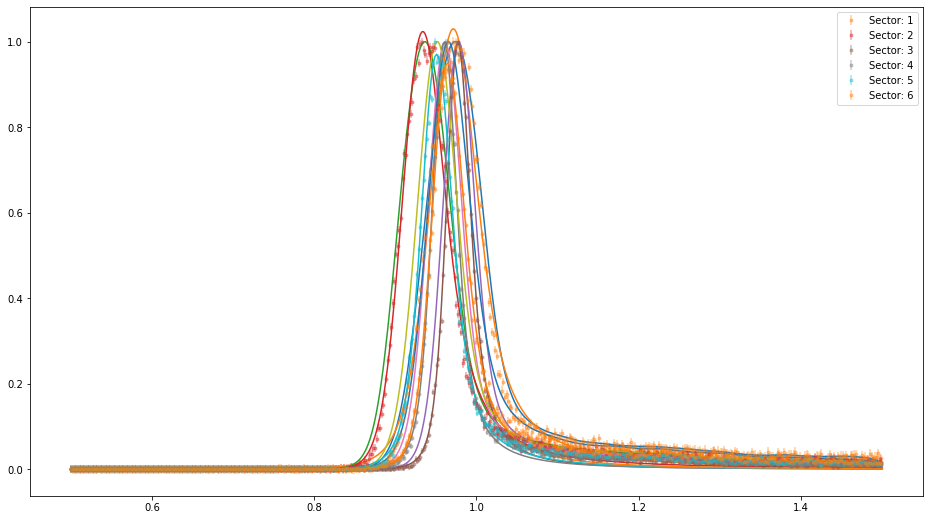

In [6]:
fig = plt.figure(figsize=(16,9))
for sec in np.unique(df.sector):
    xs=np.linspace(0.5, 1.5, 500)
    data = df[df.sector == sec]
    y, x= np.histogram(data['W_uncorr'], bins=500, range=(0.5,1.5))
    y = y/np.max(y)
    kde = stats.gaussian_kde(data['W_uncorr'])
    plt.plot(xs, kde(xs)/np.max(kde(xs)))
    x = (x[:-1]+x[1:])/2.0
    ebar = plt.errorbar(x,y, yerr=stats.sem(y),fmt='.',alpha=0.4, label=f'Sector: {sec}')
    
    #mod = BreitWignerModel()
    mod = SkewedVoigtModel()
    #mod = LorentzianModel()
    pars = mod.guess(y, x=x)
    out = mod.fit(y, pars, x=x)

    plt.plot(xs, out.eval(x=xs), 'r-', c=ebar[0].get_color())

plt.legend()
plt.show()

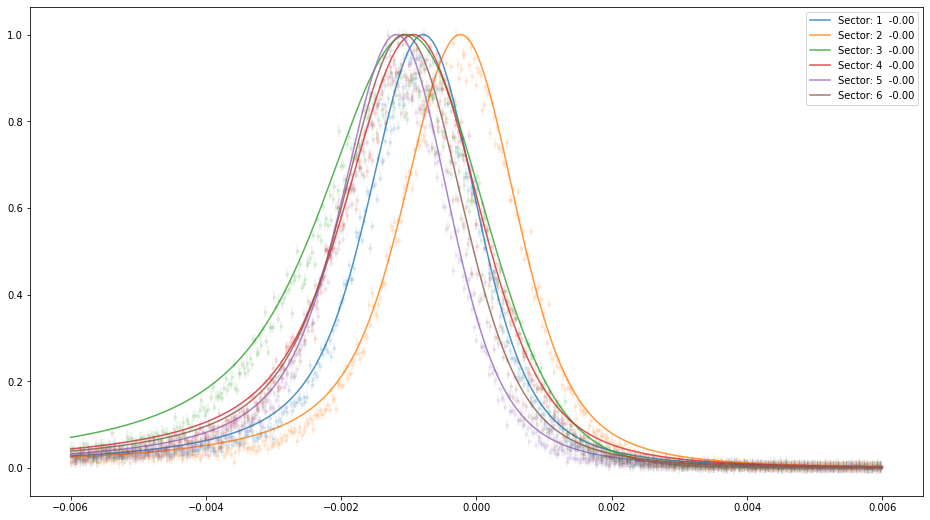

In [15]:
fig = plt.figure(figsize=(16,9))
mod = dict()
for sec in range(1,7):
    data = df[df.sector == sec]
    y,x = np.histogram(data['delta_theta'], bins=500, range=(-0.006,0.006))
    y = y/np.max(y)
    x = (x[:-1]+x[1:])/2.0
    ebar = plt.errorbar(x,y,yerr=stats.sem(y), fmt='.', alpha=0.1)
    mod[sec] = SkewedVoigtModel()
    pars = mod[sec].guess(y, x=x)
    out = mod[sec].fit(y, pars, x=x, nan_policy='omit')
    xs=np.linspace(-0.006, 0.006, 5000)
    plt.plot(xs, out.eval(x=xs)/np.max(out.eval(x=xs)),alpha=0.8, c=ebar[0].get_color(), label=f'Sector: {sec}  {out.best_values["center"]:0.2f}')

plt.legend()
plt.show()

In [75]:
num_points = 55
grr = []
for sec in range(1,7):
    for deg in range(13, 20):
        df2 = df[(df.sector == sec) & (np.rad2deg(df.e_theta) >= deg) & (np.rad2deg(df.e_theta) < deg+1)]
#         if len(df2) < 10:
#             pass
        phis = np.linspace(np.min(df2.e_phi_center), np.max(df2.e_phi_center), num_points+1)
        for phi in range(0, num_points):
            phi_min = phis[phi]
            phi_max = phis[phi+1]
            data = df2[(df2.e_phi_center > phi_min) & (df2.e_phi_center <= phi_max)]
            y, x = np.histogram(data['delta_theta'], bins=100, range=(-0.006,0.006))
            y = y/np.max(y)
            x = (x[:-1]+x[1:])/2.0

            if not np.any(np.isnan(y)) and len(y) >= 5:
                try:
                    mod = GaussianModel()
                    pars = mod.guess(y, x=x)
                    out = mod.fit(y, pars, x=x)
                    grr.append([((phi_min+phi_max) / 2.0), out.params['center'], out.params['fwhm'], sec, np.deg2rad(deg)])

                except RuntimeError:
                    pass
            
grr = np.array(grr)
dfgrr = pd.DataFrame(data=grr, columns=["phi", "dtheta", "sigma", "sec", "min_deg"])

1


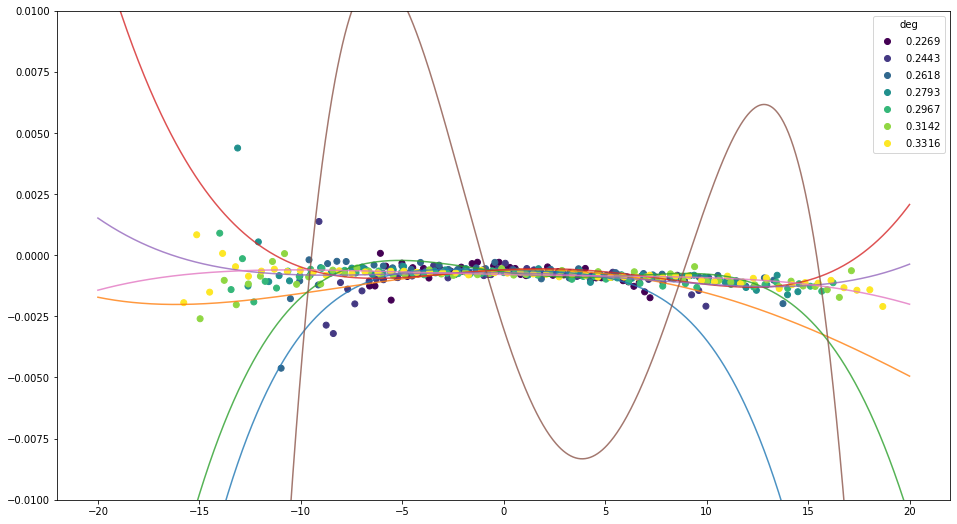

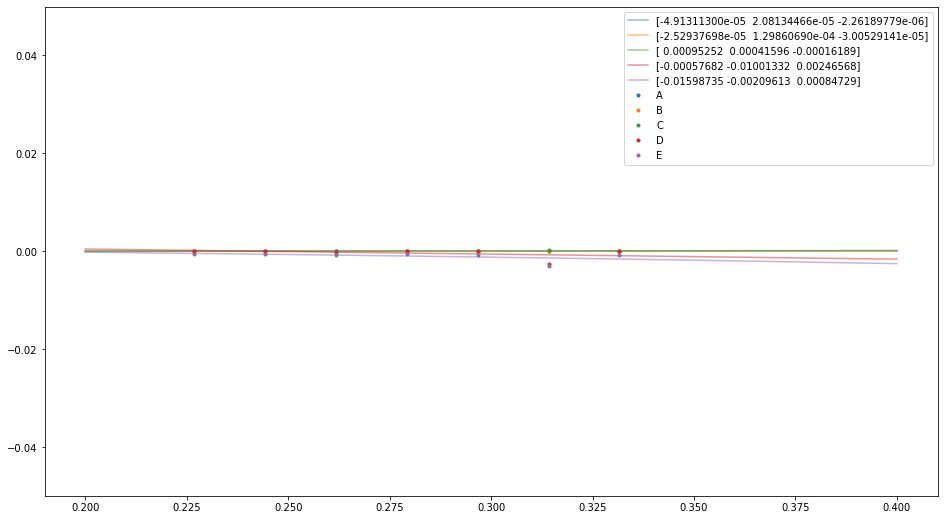

2


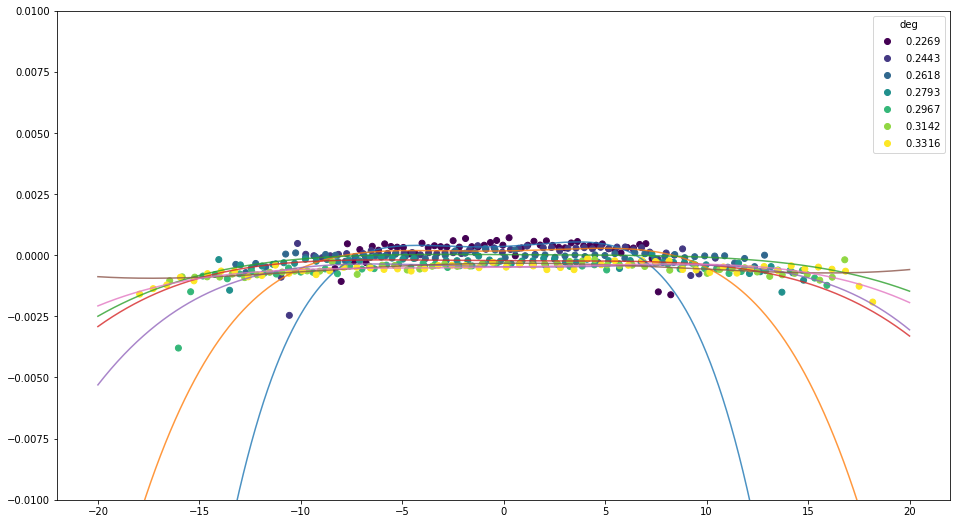

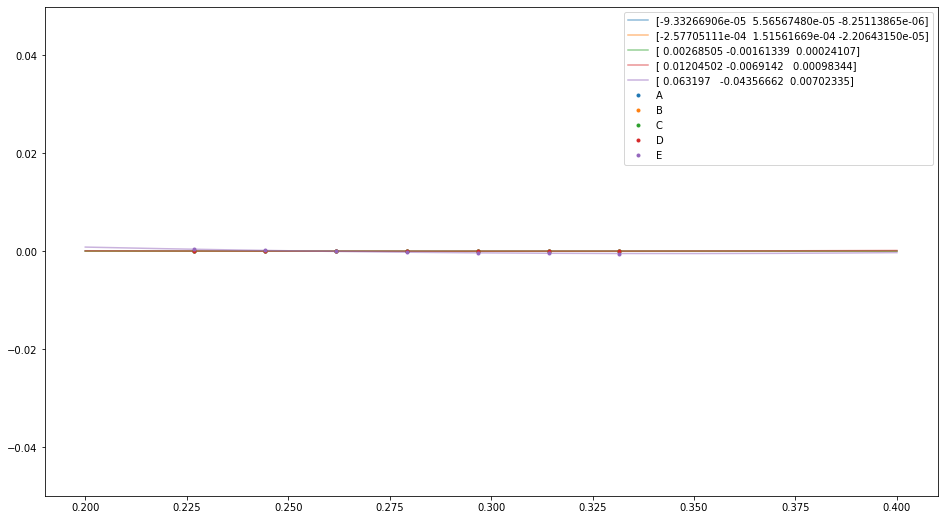

3


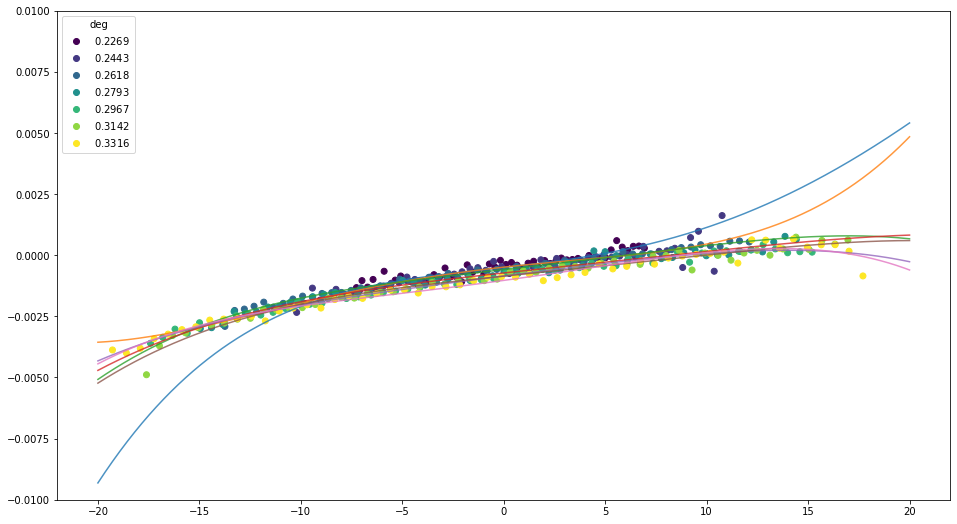

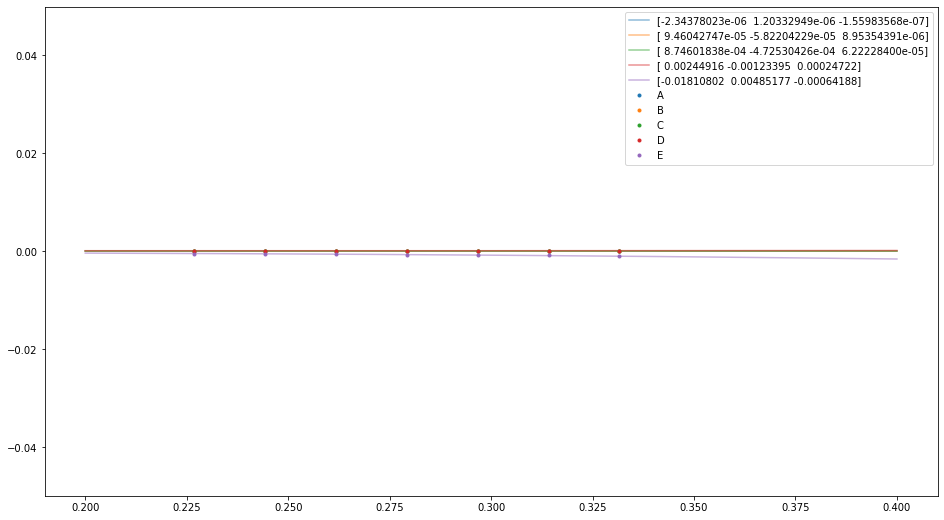

4


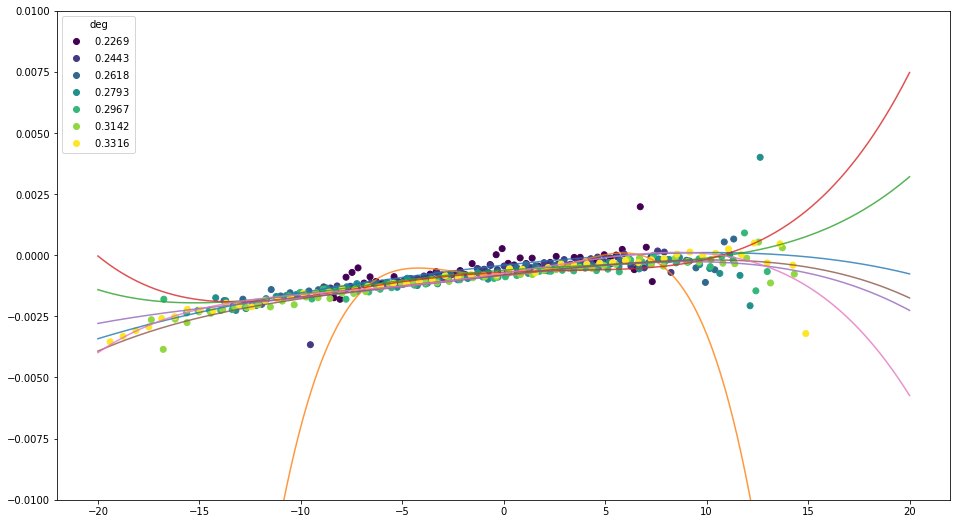

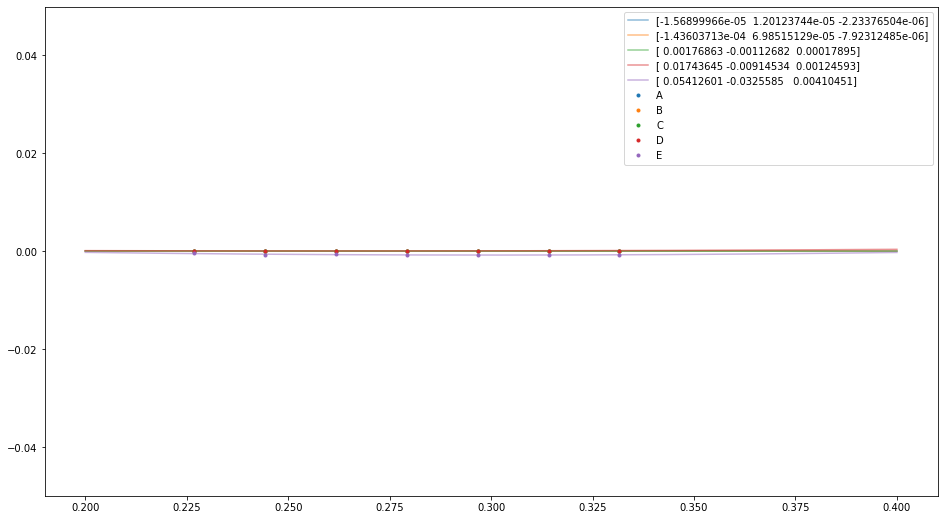

5


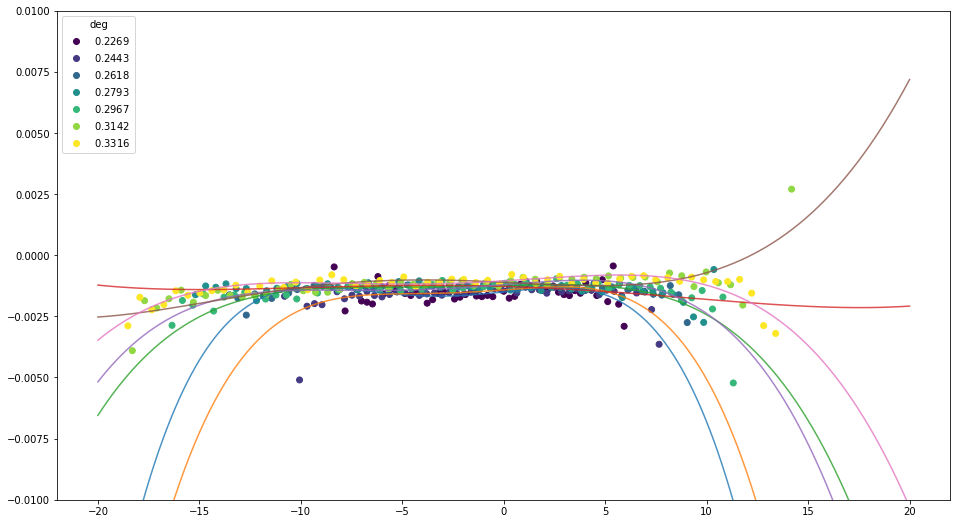

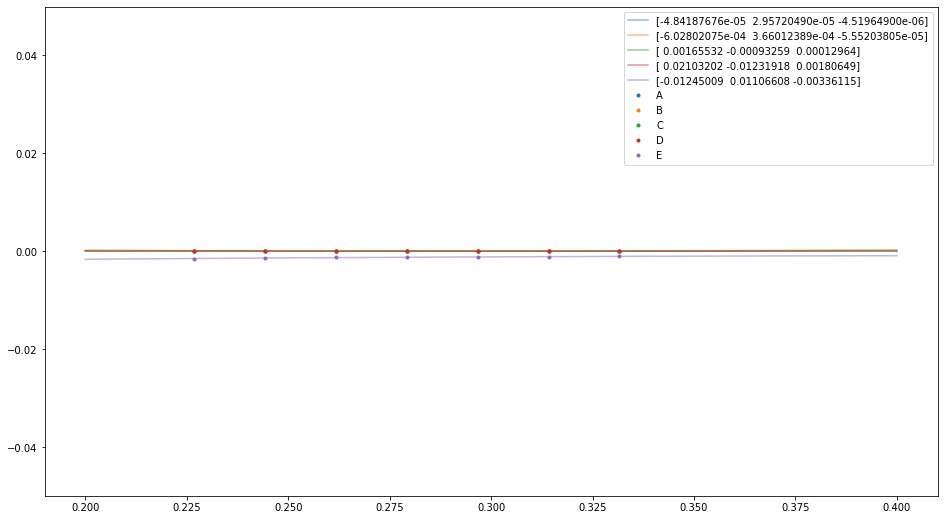

6


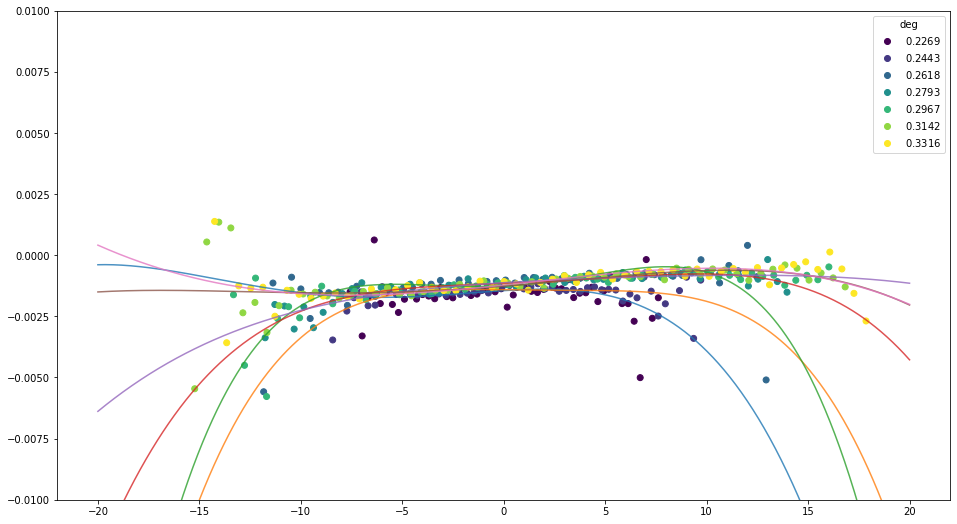

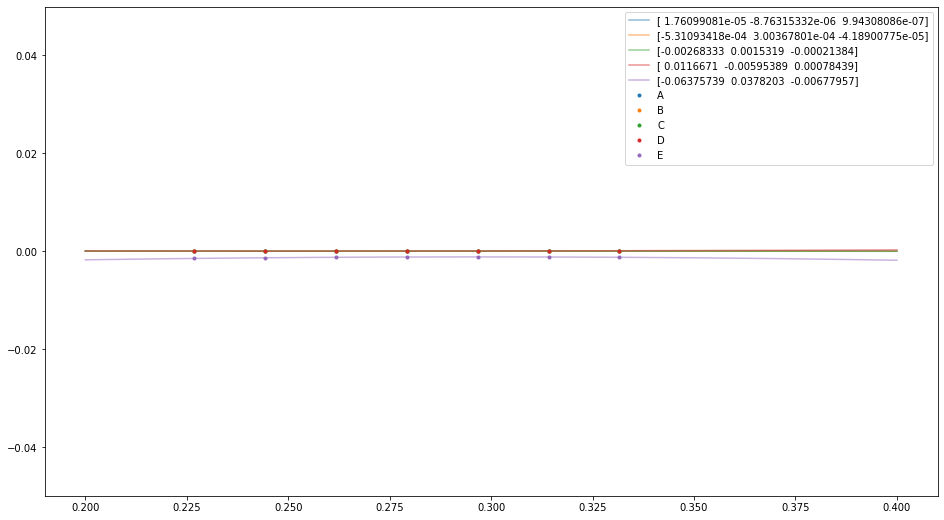

{'sec_1_A_alpha': -4.913112995022865e-05, 'sec_1_A_beta': 2.081344664781529e-05, 'sec_1_A_gamma': -2.261897788663114e-06, 'sec_1_B_alpha': -2.5293769831610483e-05, 'sec_1_B_beta': 0.00012986069016784983, 'sec_1_B_gamma': -3.0052914130852824e-05, 'sec_1_C_alpha': 0.0009525152096270553, 'sec_1_C_beta': 0.00041596297173028486, 'sec_1_C_gamma': -0.0001618914328629532, 'sec_1_D_alpha': -0.0005768183112509803, 'sec_1_D_beta': -0.010013321063089062, 'sec_1_D_gamma': 0.002465684909320018, 'sec_1_E_alpha': -0.015987349801061295, 'sec_1_E_beta': -0.002096133633897267, 'sec_1_E_gamma': 0.0008472940745040704, 'sec_2_A_alpha': -9.332669062299886e-05, 'sec_2_A_beta': 5.565674795151429e-05, 'sec_2_A_gamma': -8.251138653009375e-06, 'sec_2_B_alpha': -0.0002577051108896454, 'sec_2_B_beta': 0.0001515616685890032, 'sec_2_B_gamma': -2.2064314993858207e-05, 'sec_2_C_alpha': 0.002685047044525724, 'sec_2_C_beta': -0.0016133864258327329, 'sec_2_C_gamma': 0.00024106947418650167, 'sec_2_D_alpha': 0.0120450207753

In [76]:
final_fit_parameters = {}
for sec in range(1,7):
    print(sec)
    xs = np.linspace(-20,20,1000)
    d = dfgrr[dfgrr.sec == sec]
    fig = plt.figure(figsize=(16,9))
    scatter = plt.scatter(d.phi, d.dtheta, c=d.min_deg)
    sec_values = []
    for deg in np.unique(dfgrr.min_deg):
        d2 = dfgrr[(dfgrr.sec == sec) & (dfgrr.min_deg == deg)]
        z = np.polyfit(d2.phi, d2.dtheta, 4)
        p = np.poly1d(z)
        plt.plot(xs, p(xs), label=z, alpha=0.8)
        sec_values.append(z)

    legend = plt.legend(*scatter.legend_elements(), title="deg")
    plt.ylim(-0.01, 0.01)
    plt.show()
    
    fig = plt.figure(figsize=(16,9))
    sec_values = np.array(sec_values)

    label="ABCDE"
    for i in range(0, 5):
        sca = plt.errorbar(np.unique(dfgrr.min_deg), sec_values.T[i], fmt='.', label=label[i])
        z = np.polyfit(np.unique(dfgrr.min_deg), sec_values.T[i], 2)
        p = np.poly1d(z)
        xx = np.linspace(0.2, 0.4, 500)
        plt.plot(xx, p(xx), label=z, alpha=0.5, c=sca[0].get_color())
        for j, abc in enumerate(['alpha','beta','gamma']):
            final_fit_parameters[f'sec_{sec}_{label[i]}_{abc}'] = z[j]
    
    plt.ylim(-0.05, 0.05)
    plt.legend()
    plt.show()
    
print(final_fit_parameters)

In [77]:
dfgrr.head()

,phi,dtheta,sigma,sec,min_deg
0,-6.610485,-0.001260,0.000066,1.0,0.226893
1,-6.344688,-0.001260,0.004000,1.0,0.226893
2,-6.078891,0.000076,0.001656,1.0,0.226893
3,-5.813094,-0.000447,0.003495,1.0,0.226893
4,-5.547297,-0.001837,0.002940,1.0,0.226893


In [78]:
# for sec in range(1,7):
#     fig = plt.figure(figsize=(16,9))
#     plt.viridis()
#     d = dfgrr[dfgrr.sec == sec]
#     df2 = df[df.sector == sec]
#     #plt.hist2d(df2.e_phi_center,df2.delta_theta,bins=100, range=((-0.5,0.5),None))
#     plt.scatter(d.phi, d.dtheta)
    
#     p0=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
#     popt, pcov = curve_fit(FitFunc, d.phi, d.dtheta, p0=p0, maxfev = 3400)
#     xs = np.linspace(np.min(d.phi), np.max(d.phi), 1000000)
#     plt.plot(xs, FitFunc(xs, *popt))
        
    
#     popt, pcov = curve_fit(Dtheta, d.phi, d.dtheta, maxfev = 3400)
#     plt.plot(xs, Dtheta(xs, *popt))

#     plt.show()

In [84]:
df['theta_corr'] = df['e_theta']

#for sec in [1,5,6]:
for sec in range(1, 7):
    mask = (df.sector == sec)
    valid = df[mask].copy()
    correction = FitFunc(valid.e_phi, valid.e_theta,
            final_fit_parameters[f'sec_{sec}_A_alpha'], final_fit_parameters[f'sec_{sec}_A_beta'], final_fit_parameters[f'sec_{sec}_A_gamma'], 
            final_fit_parameters[f'sec_{sec}_B_alpha'], final_fit_parameters[f'sec_{sec}_B_beta'], final_fit_parameters[f'sec_{sec}_B_gamma'], 
            final_fit_parameters[f'sec_{sec}_C_alpha'], final_fit_parameters[f'sec_{sec}_C_beta'], final_fit_parameters[f'sec_{sec}_C_gamma'],
            final_fit_parameters[f'sec_{sec}_D_alpha'], final_fit_parameters[f'sec_{sec}_D_beta'], final_fit_parameters[f'sec_{sec}_D_gamma'],
            final_fit_parameters[f'sec_{sec}_E_alpha'], final_fit_parameters[f'sec_{sec}_E_beta'], final_fit_parameters[f'sec_{sec}_E_gamma'],)

    df.loc[mask, 'theta_corr'] = valid.e_theta - correction


df['w_corr'] = calc_W(df.e_p, df.theta_corr, df.e_phi)
df['q2_corr'] = calc_q2(df.e_p, df.theta_corr, df.e_phi)



Parameters([('amplitude', <Parameter 'amplitude', value=0.11129108718741128 +/- 0.000686, bounds=[-inf:inf]>), ('center', <Parameter 'center', value=0.9557346516692048 +/- 0.0007, bounds=[-inf:inf]>), ('sigma', <Parameter 'sigma', value=0.023397395021397482 +/- 0.000189, bounds=[0.0:inf]>), ('skew', <Parameter 'skew', value=0.10202770716597807 +/- 0.0132, bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=0.023397395021397482 +/- 0.000189, bounds=[-inf:inf], expr='sigma'>)])
Parameters([('amplitude', <Parameter 'amplitude', value=0.09717346172608579 +/- 0.000587, bounds=[-inf:inf]>), ('center', <Parameter 'center', value=0.964345935806357 +/- 0.000848, bounds=[-inf:inf]>), ('sigma', <Parameter 'sigma', value=0.020297946855323046 +/- 0.00019, bounds=[0.0:inf]>), ('skew', <Parameter 'skew', value=0.21981173100642273 +/- 0.0218, bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=0.020297946855323046 +/- 0.00019, bounds=[-inf:inf], expr='sigma'>)])


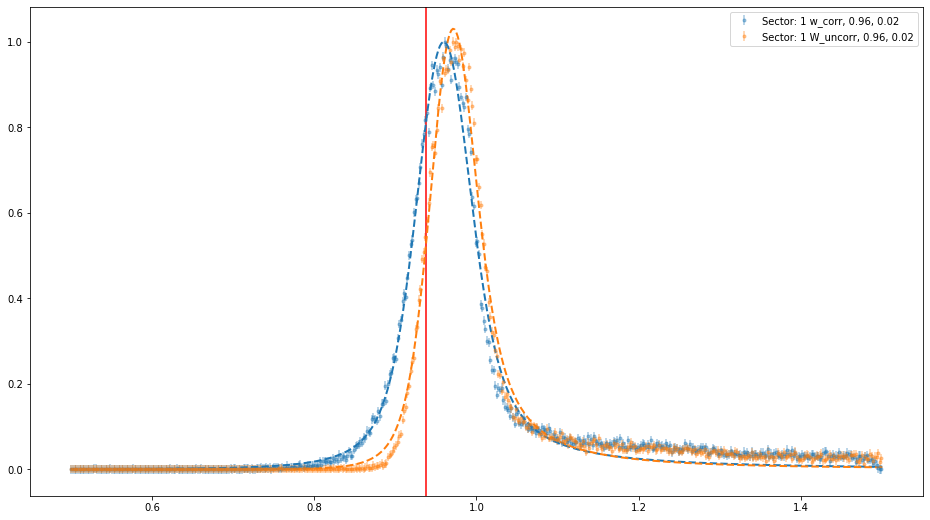

Parameters([('amplitude', <Parameter 'amplitude', value=0.08657807056798447 +/- 0.000422, bounds=[-inf:inf]>), ('center', <Parameter 'center', value=0.91951555620377 +/- 0.00124, bounds=[-inf:inf]>), ('sigma', <Parameter 'sigma', value=0.020374496349389926 +/- 0.000501, bounds=[0.0:inf]>), ('skew', <Parameter 'skew', value=0.5228361302976932 +/- 0.0559, bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=0.020374496349389926 +/- 0.000501, bounds=[-inf:inf], expr='sigma'>)])
Parameters([('amplitude', <Parameter 'amplitude', value=0.08611603733318733 +/- 0.000421, bounds=[-inf:inf]>), ('center', <Parameter 'center', value=0.9206878370796017 +/- 0.00123, bounds=[-inf:inf]>), ('sigma', <Parameter 'sigma', value=0.02003546545027457 +/- 0.000483, bounds=[0.0:inf]>), ('skew', <Parameter 'skew', value=0.5109296564163512 +/- 0.0549, bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=0.02003546545027457 +/- 0.000483, bounds=[-inf:inf], expr='sigma'>)])


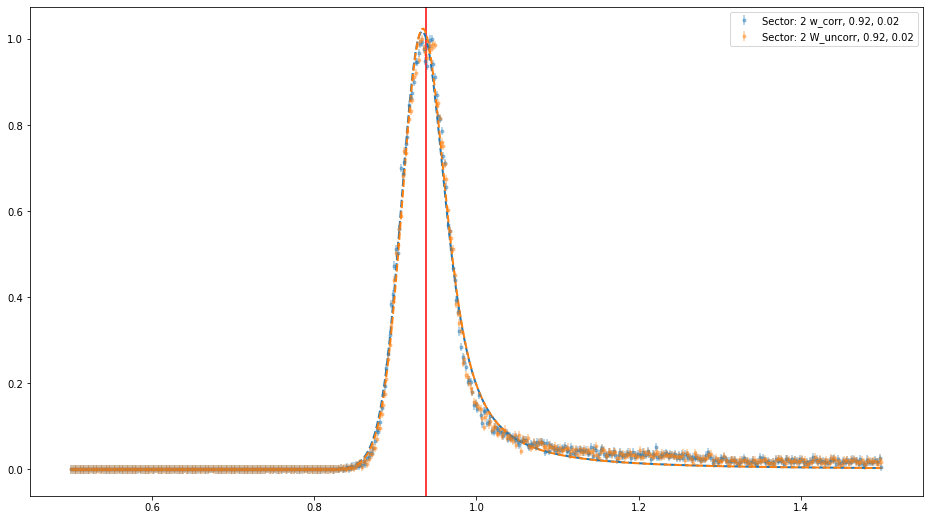

Parameters([('amplitude', <Parameter 'amplitude', value=0.04835699630770174 +/- 0.000181, bounds=[-inf:inf]>), ('center', <Parameter 'center', value=0.9689361231790928 +/- 0.000239, bounds=[-inf:inf]>), ('sigma', <Parameter 'sigma', value=0.01051289249371834 +/- 5.53e-05, bounds=[0.0:inf]>), ('skew', <Parameter 'skew', value=0.17711629634089562 +/- 0.0111, bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=0.01051289249371834 +/- 5.53e-05, bounds=[-inf:inf], expr='sigma'>)])
Parameters([('amplitude', <Parameter 'amplitude', value=0.04737483692795673 +/- 0.000178, bounds=[-inf:inf]>), ('center', <Parameter 'center', value=0.9737358509040697 +/- 0.000263, bounds=[-inf:inf]>), ('sigma', <Parameter 'sigma', value=0.010211348743892179 +/- 5.91e-05, bounds=[0.0:inf]>), ('skew', <Parameter 'skew', value=0.21735825979437862 +/- 0.0134, bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=0.010211348743892179 +/- 5.91e-05, bounds=[-inf:inf], expr='sigma'>)])


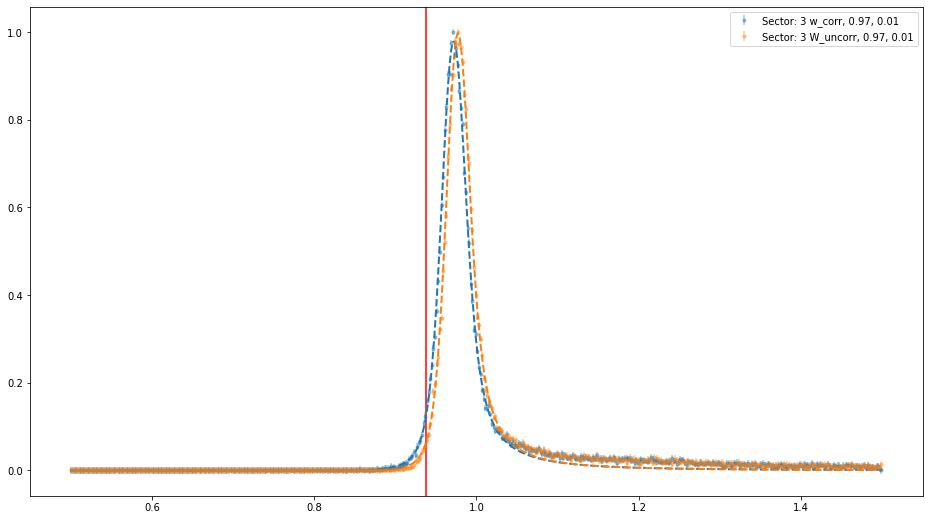

Parameters([('amplitude', <Parameter 'amplitude', value=0.05011222488918671 +/- 0.000224, bounds=[-inf:inf]>), ('center', <Parameter 'center', value=0.951970340639772 +/- 0.000307, bounds=[-inf:inf]>), ('sigma', <Parameter 'sigma', value=0.010730143630295341 +/- 6.97e-05, bounds=[0.0:inf]>), ('skew', <Parameter 'skew', value=0.19418002171474236 +/- 0.0144, bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=0.010730143630295341 +/- 6.97e-05, bounds=[-inf:inf], expr='sigma'>)])
Parameters([('amplitude', <Parameter 'amplitude', value=0.04946824192692703 +/- 0.000226, bounds=[-inf:inf]>), ('center', <Parameter 'center', value=0.9575695798699437 +/- 0.000282, bounds=[-inf:inf]>), ('sigma', <Parameter 'sigma', value=0.010512882685293157 +/- 6.63e-05, bounds=[0.0:inf]>), ('skew', <Parameter 'skew', value=0.1661599864483776 +/- 0.0129, bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=0.010512882685293157 +/- 6.63e-05, bounds=[-inf:inf], expr='sigma'>)])


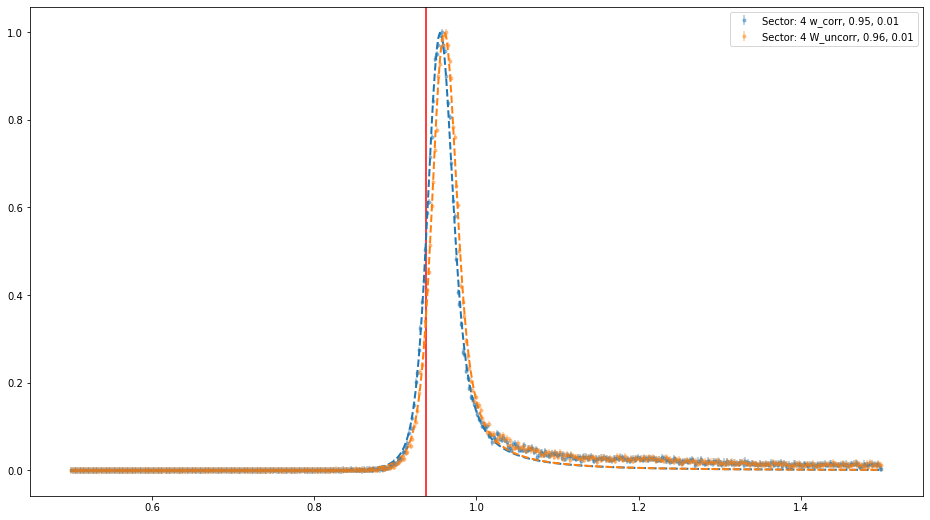

Parameters([('amplitude', <Parameter 'amplitude', value=0.061154793861258945 +/- 0.000318, bounds=[-inf:inf]>), ('center', <Parameter 'center', value=0.9391093125133008 +/- 0.000419, bounds=[-inf:inf]>), ('sigma', <Parameter 'sigma', value=0.013487736454377064 +/- 9.76e-05, bounds=[0.0:inf]>), ('skew', <Parameter 'skew', value=0.1714240107094269 +/- 0.015, bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=0.013487736454377064 +/- 9.76e-05, bounds=[-inf:inf], expr='sigma'>)])
Parameters([('amplitude', <Parameter 'amplitude', value=0.05987177951246479 +/- 0.000303, bounds=[-inf:inf]>), ('center', <Parameter 'center', value=0.9467495251149189 +/- 0.000425, bounds=[-inf:inf]>), ('sigma', <Parameter 'sigma', value=0.013182945481818864 +/- 9.66e-05, bounds=[0.0:inf]>), ('skew', <Parameter 'skew', value=0.19202540388158895 +/- 0.0161, bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=0.013182945481818864 +/- 9.66e-05, bounds=[-inf:inf], expr='sigma'>)])


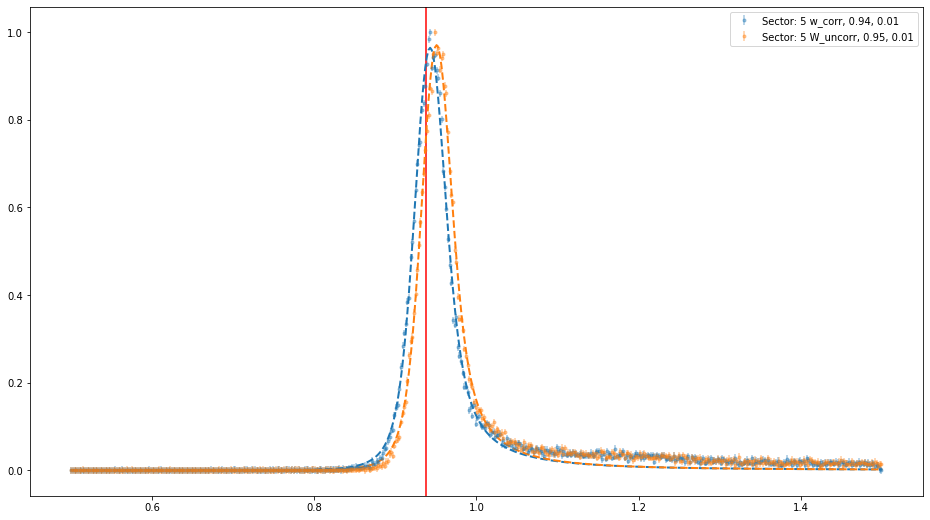

Parameters([('amplitude', <Parameter 'amplitude', value=0.06507488161457836 +/- 0.000379, bounds=[-inf:inf]>), ('center', <Parameter 'center', value=0.9519228588968148 +/- 0.000658, bounds=[-inf:inf]>), ('sigma', <Parameter 'sigma', value=0.014735868743952274 +/- 0.000149, bounds=[0.0:inf]>), ('skew', <Parameter 'skew', value=0.25403127060251807 +/- 0.0247, bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=0.014735868743952274 +/- 0.000149, bounds=[-inf:inf], expr='sigma'>)])
Parameters([('amplitude', <Parameter 'amplitude', value=0.0614231093622569 +/- 0.000354, bounds=[-inf:inf]>), ('center', <Parameter 'center', value=0.957003777985041 +/- 0.000826, bounds=[-inf:inf]>), ('sigma', <Parameter 'sigma', value=0.014480123018952629 +/- 0.000222, bounds=[0.0:inf]>), ('skew', <Parameter 'skew', value=0.3479898543946774 +/- 0.0374, bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=0.014480123018952629 +/- 0.000222, bounds=[-inf:inf], expr='sigma'>)])


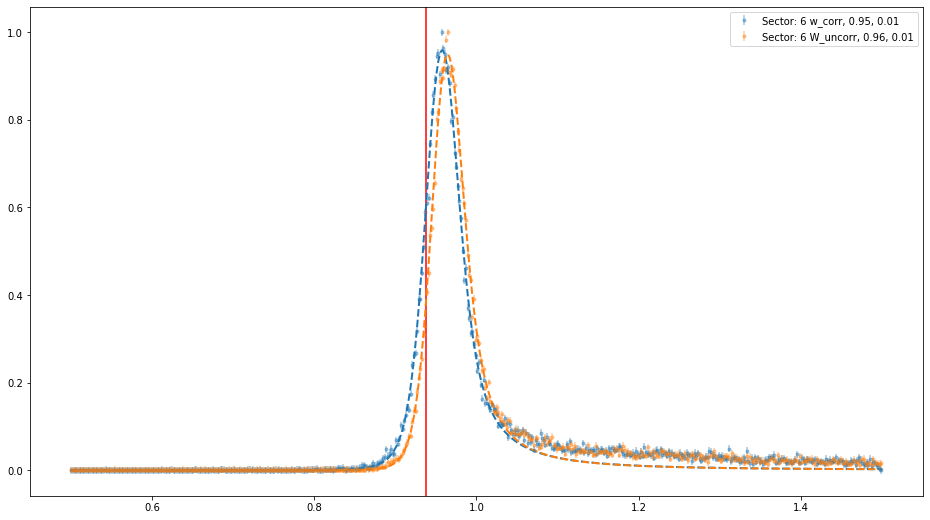

In [91]:
for sec in range(1,7):
    fig = plt.figure(figsize=(16,9))
    plt.axvline(MP, c='r')
    xs=np.linspace(0.5, 1.5, 500)
    data = df[df.sector == sec].dropna()
    for W in ['w_corr', 'W_uncorr']:
        y, x= np.histogram(data[W], bins=500, range=(0.5,1.5))
        y = y/np.max(y)
        x = (x[:-1]+x[1:])/2.0
        
        mod = SkewedVoigtModel()
        pars = mod.guess(y, x=x)
        out = mod.fit(y, pars, x=x, nan_policy='omit')
        print(out.params)
        
        ebar = plt.errorbar(x,y, yerr=stats.sem(y),fmt='.',alpha=0.4, 
                            label=f'Sector: {sec} {W}, {out.params["center"].value:0.2f}, {out.params["sigma"].value:0.2f}')
        plt.plot(xs, out.eval(x=xs), '--', c=ebar[0].get_color(), lw=2)
        
    plt.legend()
    plt.show()

In [92]:
all_data['theta_corr'] = all_data['e_theta']

#for sec in [1,5,6]:
for sec in range(1, 7):
    mask = (all_data.sector == sec)
    valid = all_data[mask]

    correction = FitFunc(valid.e_phi, valid.e_theta,
            final_fit_parameters[f'sec_{sec}_A_alpha'], final_fit_parameters[f'sec_{sec}_A_beta'], final_fit_parameters[f'sec_{sec}_A_gamma'], 
            final_fit_parameters[f'sec_{sec}_B_alpha'], final_fit_parameters[f'sec_{sec}_B_beta'], final_fit_parameters[f'sec_{sec}_B_gamma'], 
            final_fit_parameters[f'sec_{sec}_C_alpha'], final_fit_parameters[f'sec_{sec}_C_beta'], final_fit_parameters[f'sec_{sec}_C_gamma'],
            final_fit_parameters[f'sec_{sec}_D_alpha'], final_fit_parameters[f'sec_{sec}_D_beta'], final_fit_parameters[f'sec_{sec}_D_gamma'],
            final_fit_parameters[f'sec_{sec}_E_alpha'], final_fit_parameters[f'sec_{sec}_E_beta'], final_fit_parameters[f'sec_{sec}_E_gamma'],)
    all_data.loc[mask, 'theta_corr'] = valid.e_theta - correction

all_data['w_corr'] = calc_W(all_data.e_p, all_data.theta_corr, all_data.e_phi)
all_data['q2_corr'] = calc_q2(all_data.e_p, all_data.theta_corr, all_data.e_phi)

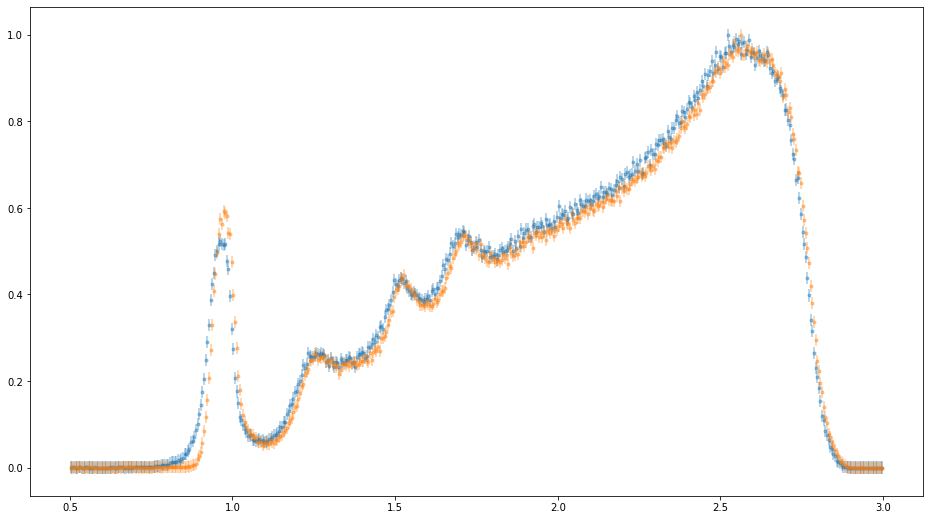

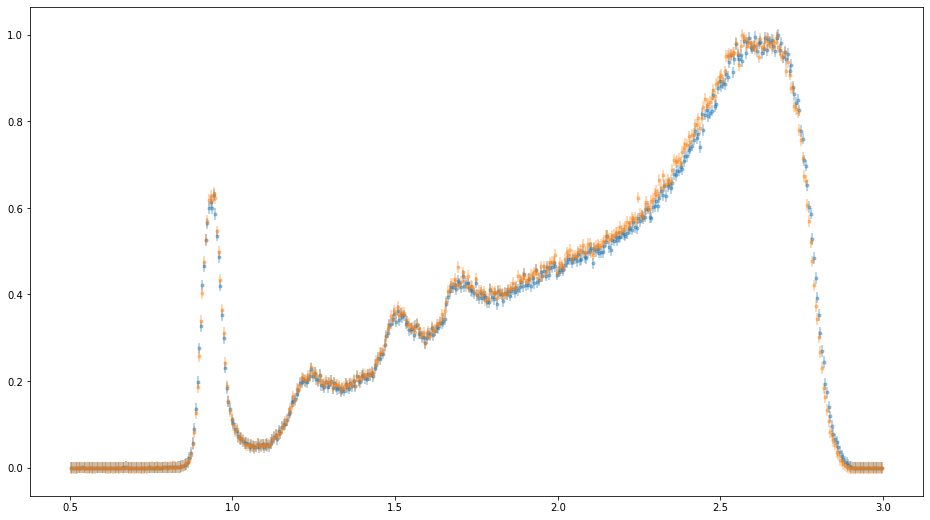

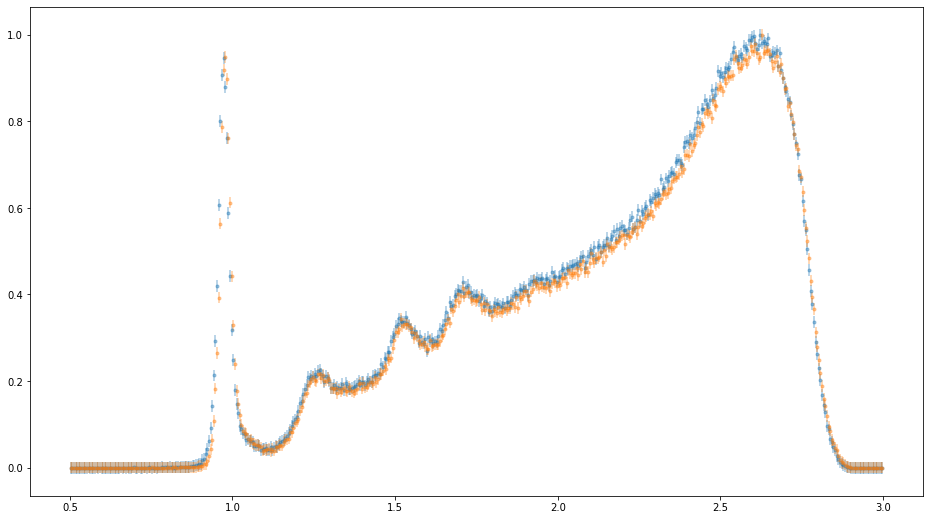

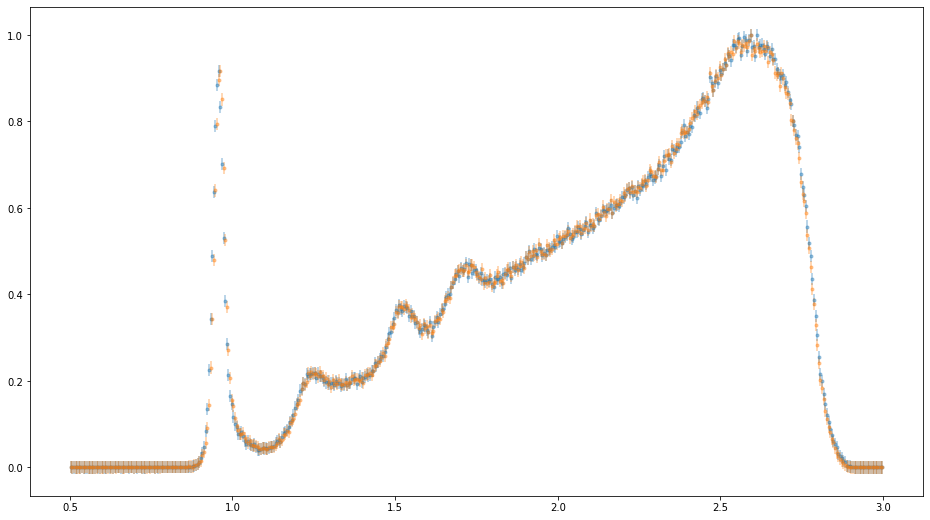

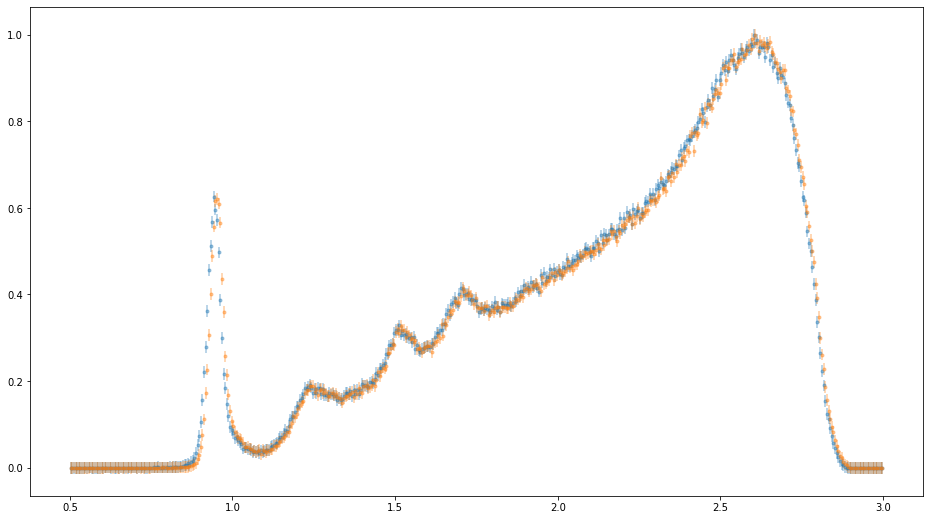

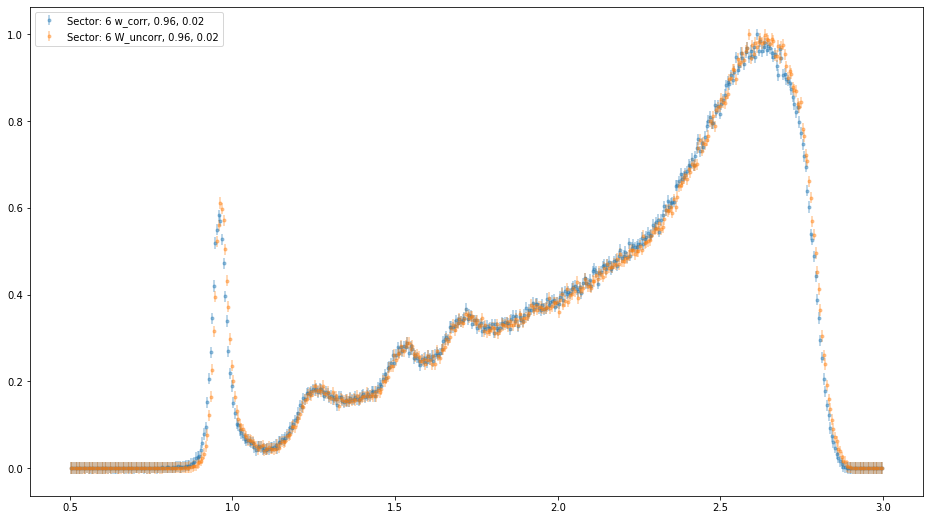

In [93]:
for sec in range(1, 7):
    fig = plt.figure(figsize=(16,9))
    xs=np.linspace(0.5, 4.5, 500)
    for W in ['w_corr', 'W_uncorr']:
        y, x= np.histogram(all_data[all_data.sector == sec][W], bins=500, range=(0.5,3.0))
        y = y/np.max(y)
        x = (x[:-1]+x[1:])/2.0
        
        ebar = plt.errorbar(x,y, yerr=stats.sem(y),fmt='.',alpha=0.4, 
                            label=f'Sector: {sec} {W}, {out.params["center"].value:0.2f}, {out.params["center"]-MP:0.2f}')


    


plt.legend()
plt.show()